# Analyze Our Default Simulations

In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

import fates_calibration_library.analysis_functions as analysis
import fates_calibration_library.ilamb_functions as ilamb
import fates_calibration_library.plotting_functions as plotting
import fates_calibration_library.utils as utils

In [2]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,                                                   # The number of cores you want
    memory='25GB',                                             # Amount of memory
    processes=1,                                               # How many processes
    queue='casper',                                            # The type of queue to utilize
    local_directory='/glade/work/afoster',                     # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB',                 # Specify resources
    log_directory='/glade/derecho/scratch/afoster/dask_logs',  # log directory
    account='P08010000',                                       # Input your project ID here
    walltime='04:00:00',                                       # Amount of wall time
    interface='ext')

In [3]:
cluster.scale(30)
dask.config.set({
    'distributed.dashboard.link': 'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
})
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.173:43781,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Set Up

First specify history variables and variables to investigate

In [4]:
fates_vars = ['FATES_FRACTION', 'FATES_GPP', 'FATES_LAI', 'QVEGE',
              'QSOIL', 'QVEGT', 'EFLX_LH_TOT', 'FSH', 'FSR', 'FSDS', 'FSA',
              'FIRE', 'FLDS', 'FCTR', 'FCEV', 'FGEV', 'BTRANMN',
              'FGR', 'SOILWATER_10CM', 'TWS', 'QRUNOFF', 'SNOWDP',
              'TV', 'TG', 'TSA', 'RH2M', 'SNOW', 'RAIN', 'FGR12',
             'TREFMXAV', 'TREFMNAV']

clm_vars = ['FPSN', 'TLAI', 'QVEGE', 'QVEGT', 'EFLX_LH_TOT', 'FSH',
            'QSOIL', 'FSR', 'FSDS', 'FSA', 'FIRE', 'FLDS', 'FCTR', 'FCEV',
            'FGEV', 'BTRANMN', 'FGR', 'SOILWATER_10CM', 'TWS', 'FGR12',
            'QRUNOFF', 'SNOWDP', 'TV', 'TG', 'TSA','RH2M', 'SNOW', 'RAIN',
           'TREFMXAV', 'TREFMNAV', 'RH2M']

out_vars = ['GPP', 'LAI', 'EFLX_LH_TOT', 'FSH', 'EF', 'SOILWATER_10CM', 'ASA',
            'FSDS', 'FSR', 'FSA', 'FIRE', 'RLNS', 'RN', 'BTRANMN', 'TV', 'Temp',
            'RH2M', 'Precip']

### Files Needed

In [5]:
# sparse grid clustering file
grid_dir = '/glade/work/afoster/FATES_calibration/surfdata'
grid_file = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
sparse_grid = xr.open_dataset(os.path.join(grid_dir, grid_file))

# sparse grid whittaker biomes
whittaker_ds = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/whittaker/whitkey.nc')

# fetch the sparsegrid landarea - needed for unit conversion
land_area_file = '/glade/work/afoster/FATES_calibration/CLM5PPE/postp/sparsegrid_landarea.nc'
land_area = xr.open_dataset(land_area_file).landarea

# create a global land frac and area grid
land_frac_ds = os.path.join("/glade/derecho/scratch/afoster/archive",
                            "ctsm60SP_bigleaf_fullgrid/lnd/hist",
                            "ctsm60SP_bigleaf_fullgrid.clm2.h0.0001-02-01-00000.nc")
target_grid = analysis.create_target_grid(land_frac_ds, 'FSR')


# config file with conversion information in it
var_config = '/glade/work/afoster/FATES_calibration/fates_calibration_library/configs/model_conversion.yaml'
var_dict = utils.get_config_file(var_config)

# ilamb observations
ilamb_config_file = '/glade/work/afoster/FATES_calibration/fates_calibration_library/configs/ilamb_conversion.yaml'
ilamb_config = utils.get_config_file(ilamb_config_file)
ilamb_obs = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/all_ILAMB_obs.nc')

## Read in Datasets

In [8]:
# FATES run with GSWP3
fates_gswp3_dir = '/glade/derecho/scratch/afoster/archive/ctsm60SP_fates_sparse_vai_default_latest/lnd/hist'
fates_gswp3 = analysis.post_process_ds(fates_gswp3_dir, fates_vars, whittaker_ds,
                                     years=[2000, 2015], run_dict={'filter_nyears': 20})

In [9]:
# FATES sparse grid run - latest tag
fates_crujra_dir = '/glade/derecho/scratch/afoster/archive/ctsm60SP_fates_sparse_crujra/lnd/hist'
fates_crujra = analysis.post_process_ds(fates_crujra_dir, fates_vars, whittaker_ds,
                                     years=[2000, 2015], run_dict={'filter_nyears': 20})

## Post-Process Datasets


### Temporal Averaging
First calculate annual and monthly means

In [10]:
# annual means
fates_gswp3_annmeans = analysis.apply_to_vars(fates_gswp3, out_vars, func=analysis.calculate_annual_mean, add_sparse=True,
                                         conversion_factor={var: var_dict[var]["time_conversion_factor"] for var in out_vars},
                                         new_units={var: var_dict[var]["annual_units"] for var in out_vars})

fates_crujra_annmeans = analysis.apply_to_vars(fates_crujra, out_vars, func=analysis.calculate_annual_mean, add_sparse=True,
                                         conversion_factor={var: var_dict[var]["time_conversion_factor"] for var in out_vars},
                                         new_units={var: var_dict[var]["annual_units"] for var in out_vars})

In [11]:
fates_gswp3_annmeans['ASA'] = fates_gswp3_annmeans['FSR']/fates_gswp3_annmeans['FSDS']
fates_crujra_annmeans['ASA'] = fates_crujra_annmeans['FSR']/fates_crujra_annmeans['FSDS']

fates_gswp3_annmeans['EF'] = fates_gswp3_annmeans['EFLX_LH_TOT']/(fates_gswp3_annmeans['EFLX_LH_TOT'] + fates_gswp3_annmeans['FSH'])
fates_crujra_annmeans['EF'] = fates_crujra_annmeans['EFLX_LH_TOT']/(fates_crujra_annmeans['EFLX_LH_TOT']+ fates_gswp3_annmeans['FSH'])

In [12]:
fates_gswp3_annmeans = fates_gswp3_annmeans.mean(dim='year')
fates_crujra_annmeans = fates_crujra_annmeans.mean(dim='year')

In [13]:
# monthly means
fates_gswp3_monthmeans = analysis.apply_to_vars(fates_gswp3, out_vars,
                                         func=analysis.calculate_monthly_mean,
                                         add_sparse=True,
                                         conversion_factor={var: var_dict[var]["time_conversion_factor"] for var in out_vars})

fates_crujra_monthmeans = analysis.apply_to_vars(fates_crujra, out_vars,
                                         func=analysis.calculate_monthly_mean,
                                         add_sparse=True,
                                         conversion_factor={var: var_dict[var]["time_conversion_factor"] for var in out_vars})

### Remap Sparse Grid

Remap the annual and monthly sparse means to a global grid

In [14]:
# maps from the annual means
fates_glob_gswp3 = analysis.get_sparse_maps(fates_gswp3_annmeans, sparse_grid, out_vars)

fates_glob_crujra = analysis.get_sparse_maps(fates_crujra_annmeans, sparse_grid, out_vars)

In [15]:
fates_monthmax_gswp3 = analysis.apply_to_vars(fates_gswp3_monthmeans, out_vars,
                                         func=lambda x: x.idxmax(dim="month"),
                                         add_sparse=True)
fates_monthmax_crujra = analysis.apply_to_vars(fates_crujra_monthmeans, out_vars,
                                         func=lambda x: x.idxmax(dim="month"),
                                         add_sparse=True)

fates_monthmax_gswp3_glob = analysis.get_sparse_maps(fates_monthmax_gswp3, sparse_grid,
                                     out_vars)

fates_monthmax_crujra_glob = analysis.get_sparse_maps(fates_monthmax_crujra, sparse_grid,
                                     out_vars)

### Zonal Means
Calculate zonal means (by latitude)

In [16]:
# zonal means
fates_zonal_gswp3 = analysis.apply_to_vars(fates_glob_gswp3, out_vars,
                                         func=analysis.calculate_zonal_mean,
                                         add_sparse=False,
                                         land_area=target_grid.land_area,
                                         conversion_factor={var: var_dict[var]["area_conversion_factor"] for var in out_vars})

fates_zonal_crujra = analysis.apply_to_vars(fates_glob_crujra, out_vars,
                                         func=analysis.calculate_zonal_mean,
                                         add_sparse=False,
                                         land_area=target_grid.land_area,
                                         conversion_factor={var: var_dict[var]["area_conversion_factor"] for var in out_vars})

### Climatology
Calculate climatology

In [17]:
# area means from monthly
fates_clim_gswp3 = analysis.get_sparse_area_means(fates_gswp3_monthmeans, 'global',
                                                out_vars, var_dict, land_area,
                                                fates_gswp3.biome)

fates_clim_crujra = analysis.get_sparse_area_means(fates_crujra_monthmeans, 'global',
                                                out_vars, var_dict, land_area,
                                                fates_crujra.biome)

### Calculate Global Annual Values

Area-weighted averages

In [18]:
# sparse area means
fates_areameans_gswp3 = analysis.get_sparse_area_means(fates_gswp3_annmeans,
                                            'global', out_vars,
                                            var_dict, land_area, fates_gswp3.biome)

fates_areameans_crujra = analysis.get_sparse_area_means(fates_crujra_annmeans,
                                            'global', out_vars,
                                            var_dict, land_area, fates_crujra.biome)

## CRU-JRA vs. GSWP3
### Annual Maps

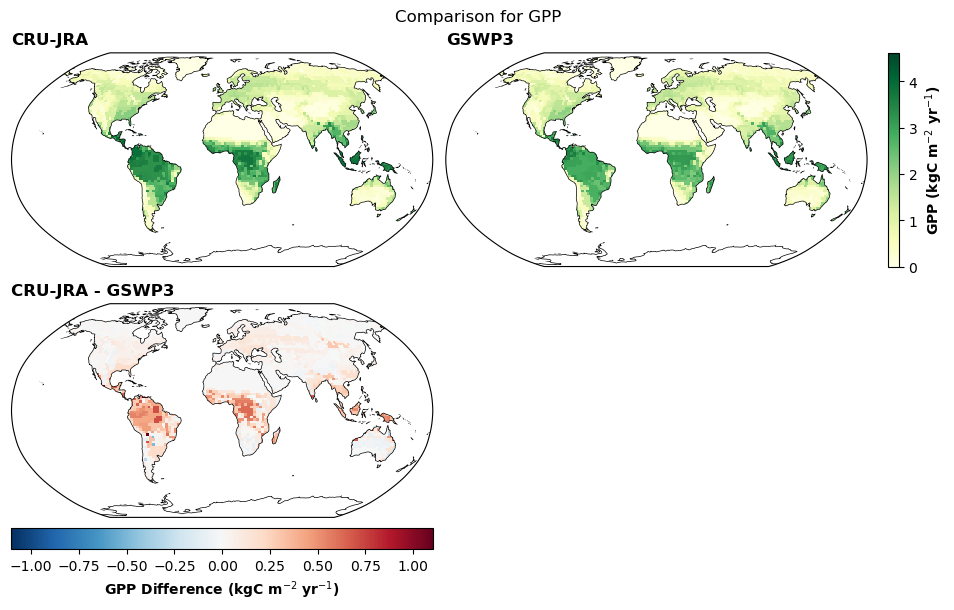

In [64]:
var = 'GPP'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

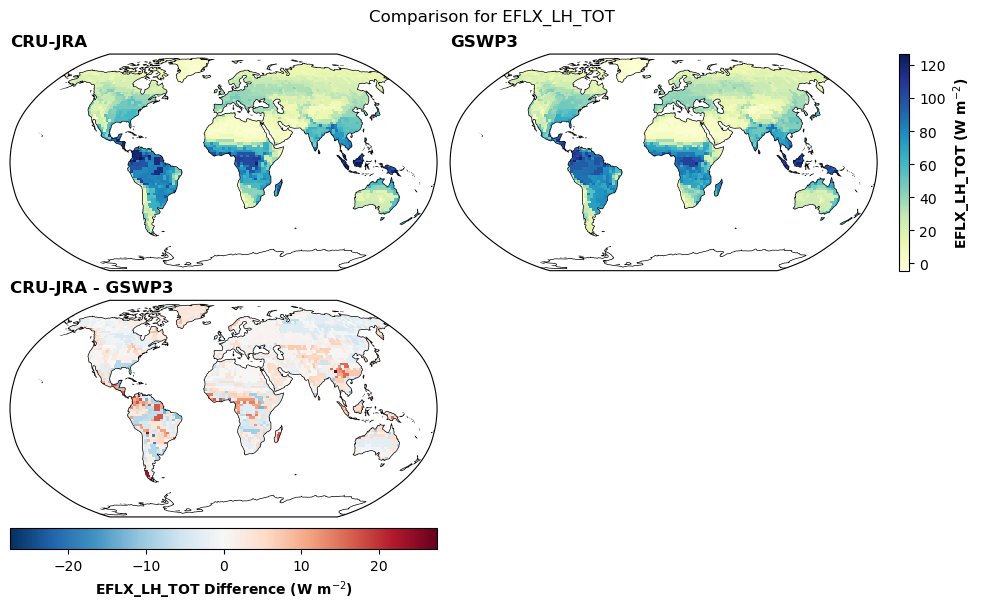

In [65]:
var = 'EFLX_LH_TOT'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

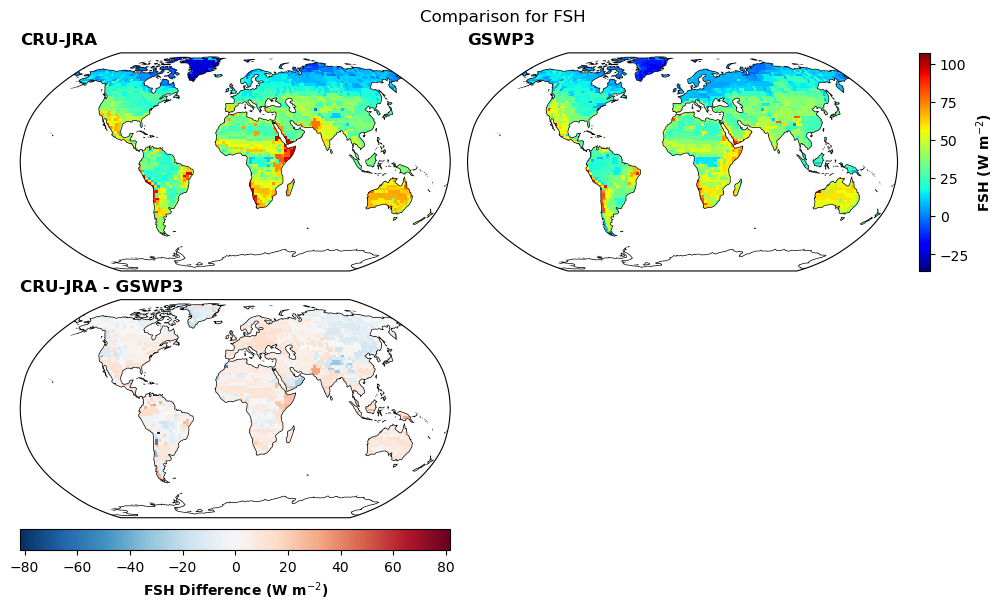

In [66]:
var = 'FSH'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

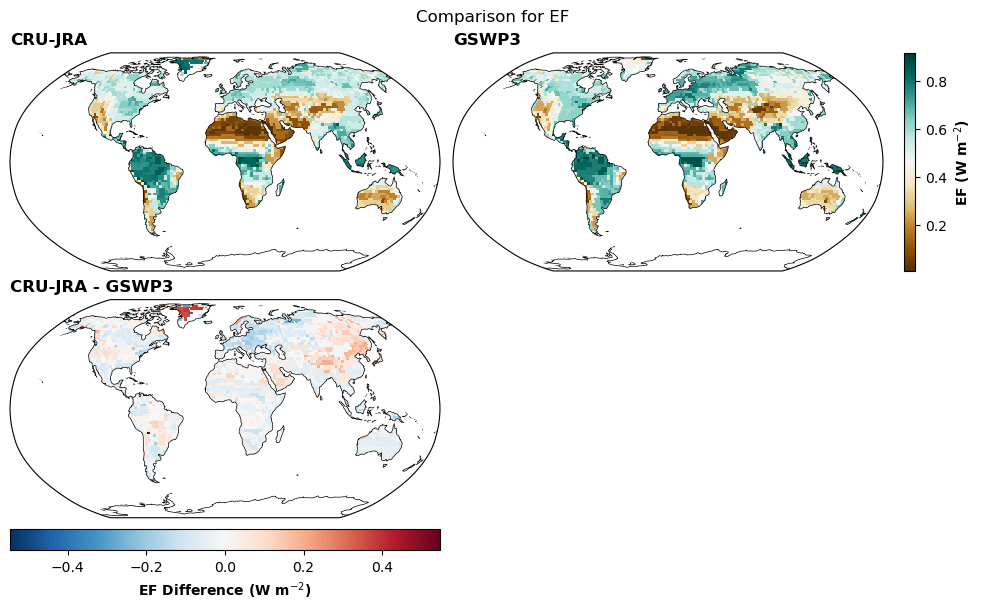

In [67]:
var = 'EF'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

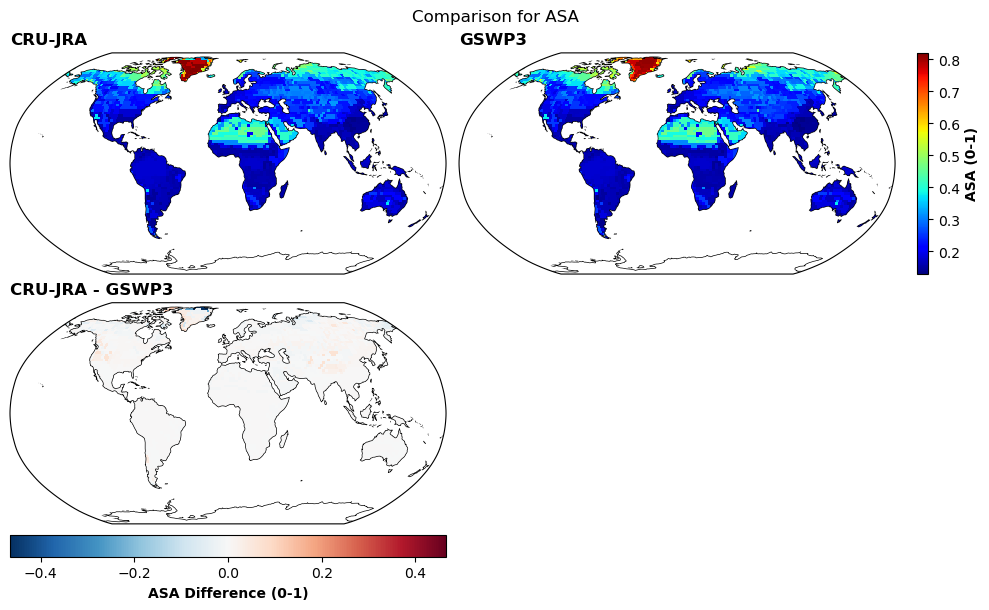

In [68]:
var = 'ASA'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

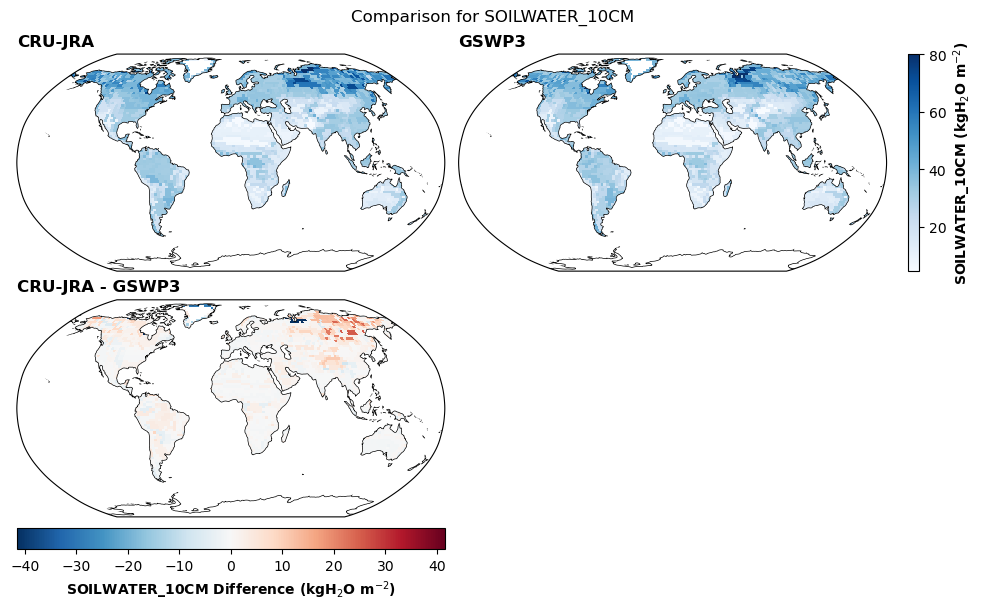

In [69]:
var = 'SOILWATER_10CM'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

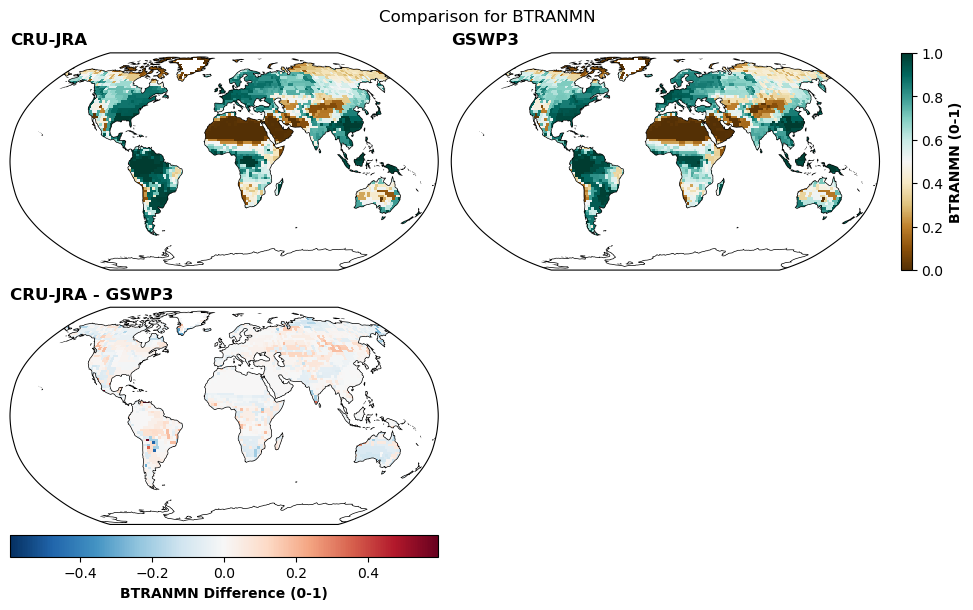

In [70]:
var = 'BTRANMN'
plotting.plot_two_model_diff(fates_glob_gswp3[var], fates_glob_crujra[var],
                             'GSWP3', 'CRU-JRA', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

### Zonal Means

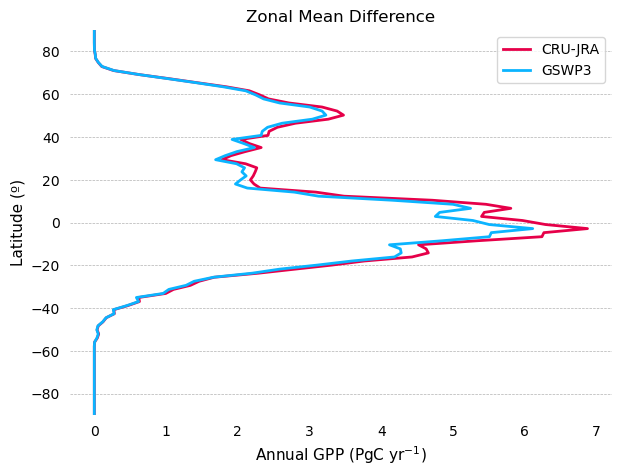

In [71]:
var_name = 'GPP'
plotting.plot_zonal_mean_diff([fates_zonal_gswp3[var_name], fates_zonal_crujra[var_name]],
                              ['GSWP3', 'CRU-JRA'], var_name, var_dict[var_name]['long_name'],
                              var_dict[var_name]['global_units'])

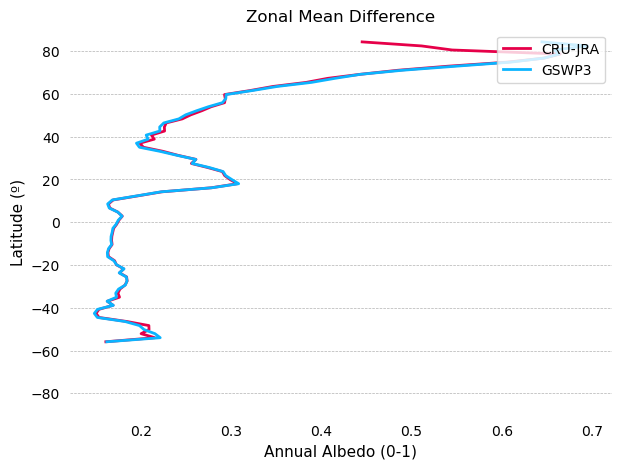

In [72]:
var_name = 'ASA'
plotting.plot_zonal_mean_diff([fates_zonal_gswp3[var_name], fates_zonal_crujra[var_name]],
                              ['GSWP3', 'CRU-JRA'], var_name, var_dict[var_name]['long_name'],
                              var_dict[var_name]['global_units'])

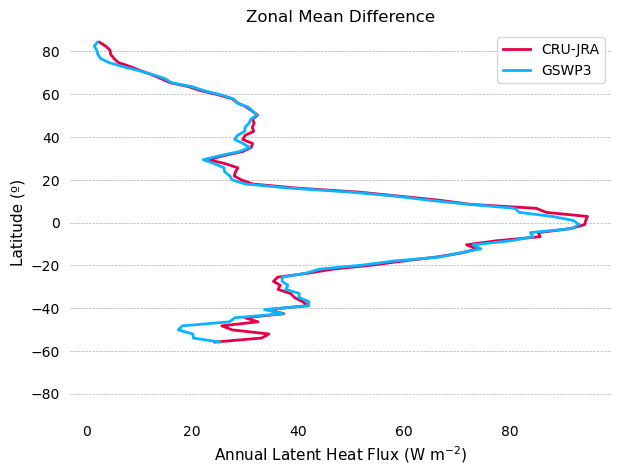

In [73]:
var_name = 'EFLX_LH_TOT'
plotting.plot_zonal_mean_diff([fates_zonal_gswp3[var_name], fates_zonal_crujra[var_name]],
                              ['GSWP3', 'CRU-JRA'], var_name, var_dict[var_name]['long_name'],
                              var_dict[var_name]['global_units'])

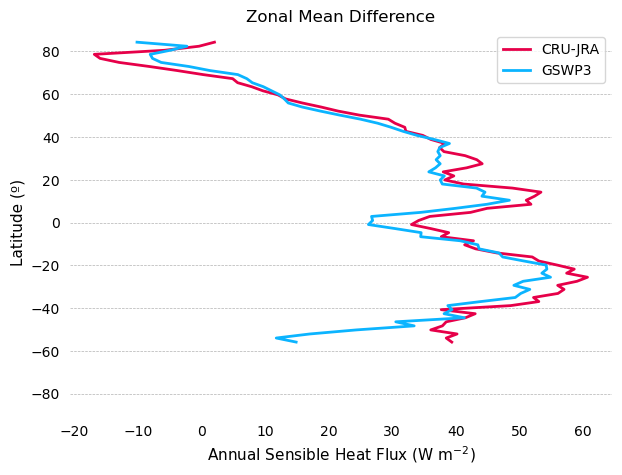

In [74]:
var_name = 'FSH'
plotting.plot_zonal_mean_diff([fates_zonal_gswp3[var_name], fates_zonal_crujra[var_name]],
                              ['GSWP3', 'CRU-JRA'], var_name, var_dict[var_name]['long_name'],
                              var_dict[var_name]['global_units'])

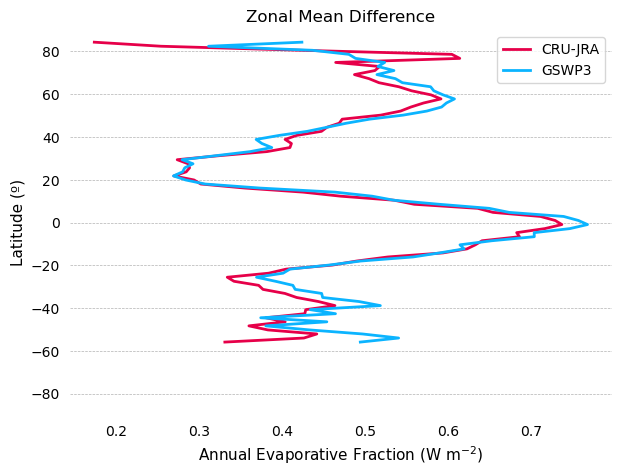

In [75]:
var_name = 'EF'
plotting.plot_zonal_mean_diff([fates_zonal_gswp3[var_name], fates_zonal_crujra[var_name]],
                              ['GSWP3', 'CRU-JRA'], var_name, var_dict[var_name]['long_name'],
                              var_dict[var_name]['global_units'])

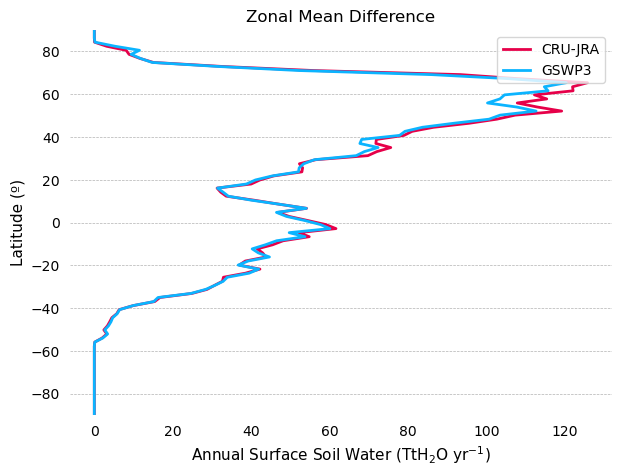

In [76]:
var_name = 'SOILWATER_10CM'
plotting.plot_zonal_mean_diff([fates_zonal_gswp3[var_name], fates_zonal_crujra[var_name]],
                              ['GSWP3', 'CRU-JRA'], var_name, var_dict[var_name]['long_name'],
                              var_dict[var_name]['global_units'])

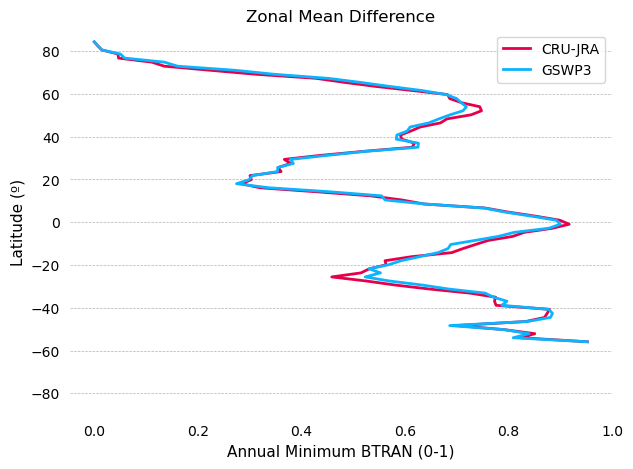

In [77]:
var_name = 'BTRANMN'
plotting.plot_zonal_mean_diff([fates_zonal_gswp3[var_name], fates_zonal_crujra[var_name]],
                              ['GSWP3', 'CRU-JRA'], var_name, var_dict[var_name]['long_name'],
                              var_dict[var_name]['global_units'])

### Climatology

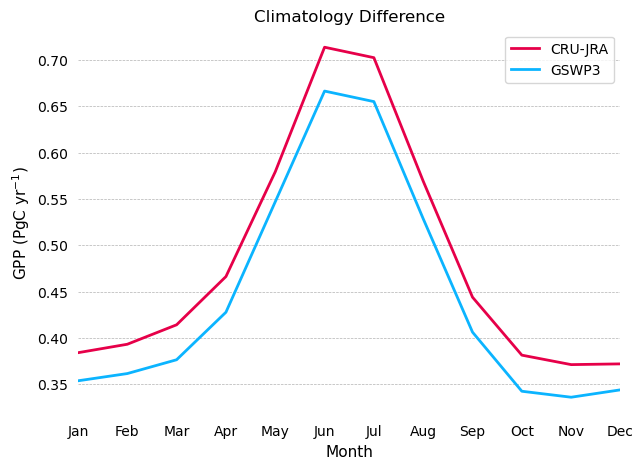

In [78]:
var = 'GPP'
plotting.plot_annual_cycle_diff(fates_clim_gswp3[var], fates_clim_crujra[var],
                                "GSWP3", "CRU-JRA", var, var, var_dict[var]['global_units'])

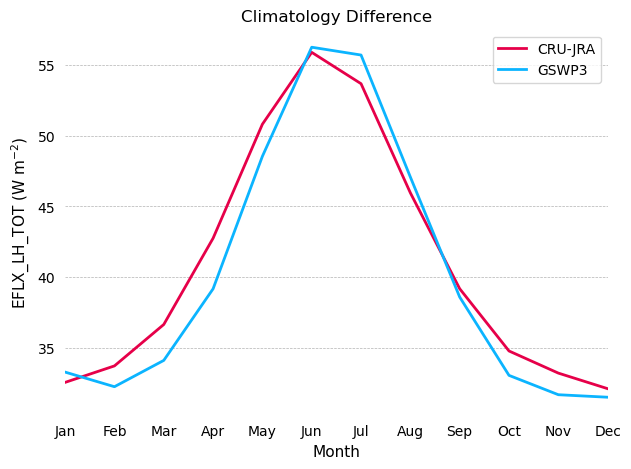

In [79]:
var = 'EFLX_LH_TOT'
plotting.plot_annual_cycle_diff(fates_clim_gswp3[var], fates_clim_crujra[var],
                                "GSWP3", "CRU-JRA", var, var, var_dict[var]['global_units'])

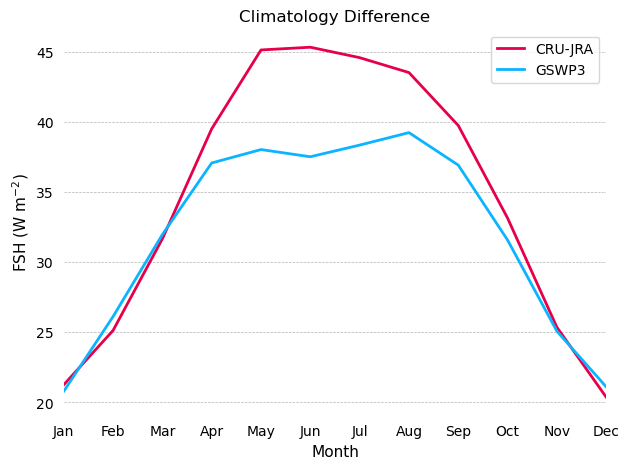

In [80]:
var = 'FSH'
plotting.plot_annual_cycle_diff(fates_clim_gswp3[var], fates_clim_crujra[var],
                                "GSWP3", "CRU-JRA", var, var, var_dict[var]['global_units'])

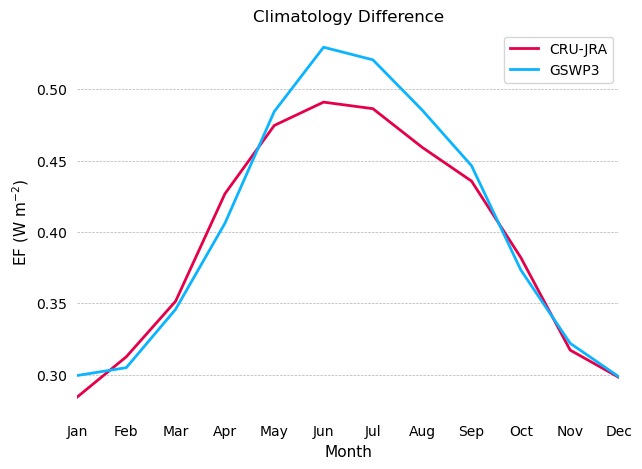

In [81]:
var = 'EF'
plotting.plot_annual_cycle_diff(fates_clim_gswp3[var], fates_clim_crujra[var],
                                "GSWP3", "CRU-JRA", var, var, var_dict[var]['global_units'])

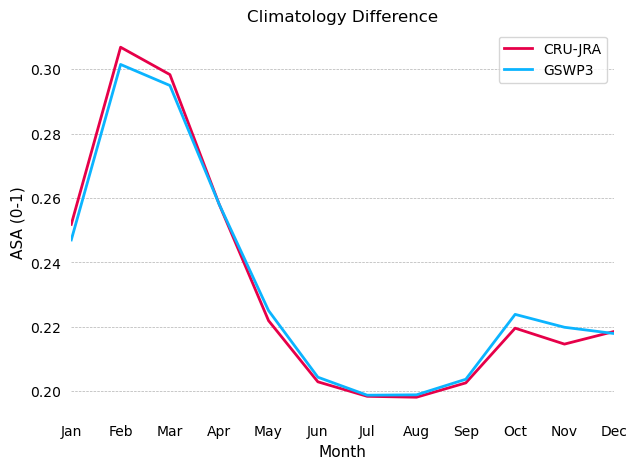

In [82]:
var = 'ASA'
plotting.plot_annual_cycle_diff(fates_clim_gswp3[var], fates_clim_crujra[var],
                                "GSWP3", "CRU-JRA", var, var, var_dict[var]['global_units'])

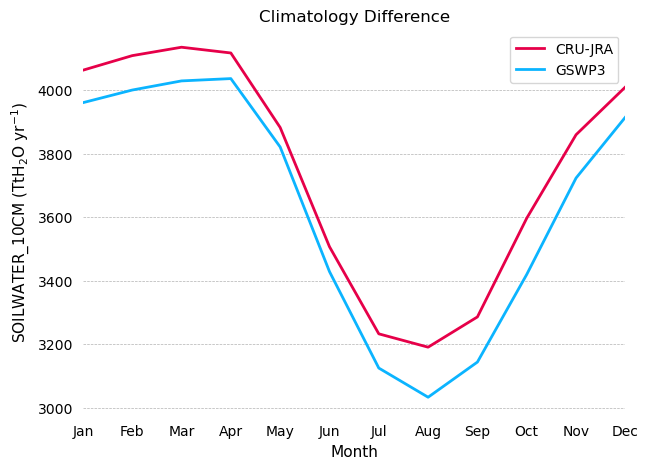

In [83]:
var = 'SOILWATER_10CM'
plotting.plot_annual_cycle_diff(fates_clim_gswp3[var], fates_clim_crujra[var],
                                "GSWP3", "CRU-JRA", var, var, var_dict[var]['global_units'])

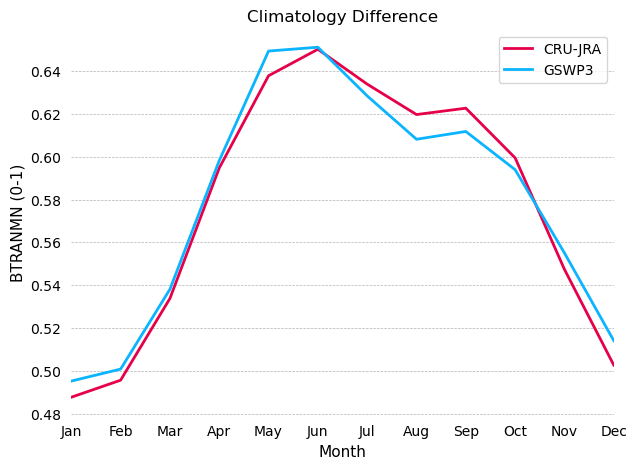

In [84]:
var = 'BTRANMN'
plotting.plot_annual_cycle_diff(fates_clim_gswp3[var], fates_clim_crujra[var],
                                "GSWP3", "CRU-JRA", var, var, var_dict[var]['global_units'])

### Global Annual Values

In [85]:
summary_df = plotting.summarize_differences(fates_areameans_gswp3, fates_areameans_crujra,
                                            'GSWP3', 'CRU-JRA', var_dict)

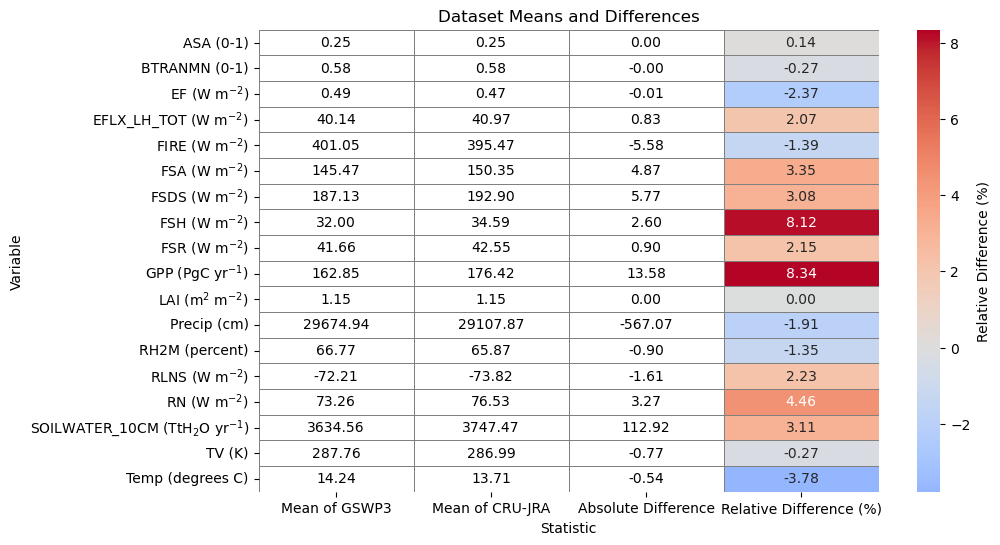

In [86]:
plotting.plot_heatmap(summary_df)

## Observational Comparisons
### Annual Maps

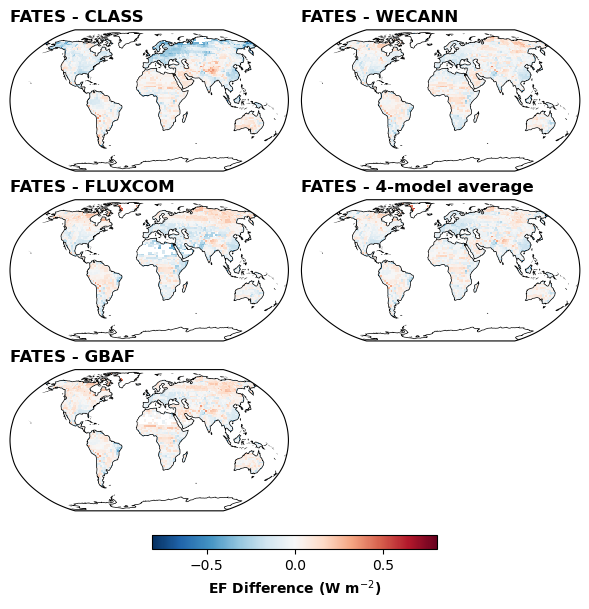

In [36]:
var = 'EF'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var]['var'], ilamb_config[var]['models']).sel(year=slice(2000, 2014))
ilamb_var = ilamb_var.dropna(dim='year', how='all').mean(dim='year')
plotting.plot_model_obs_diff(fates_glob_crujra, ilamb_var, target_grid.landfrac, var,
                             var_dict[var]['annual_units'], 'FATES')

### Zonal Means

In [50]:
import importlib
importlib.reload(analysis)
importlib.reload(ilamb)
importlib.reload(plotting)

<module 'fates_calibration_library.plotting_functions' from '/glade/work/afoster/FATES_calibration/fates_calibration_library/fates_calibration_library/plotting_functions.py'>

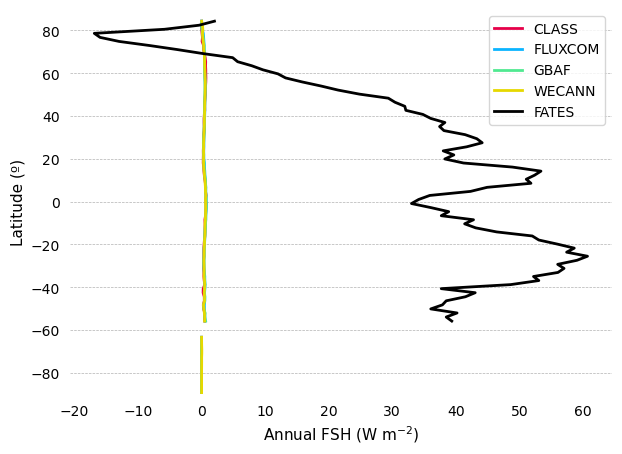

In [56]:
var_name = 'FSH'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var]['var'], ilamb_config[var]['models']).sel(year=slice(2000, 2014))
ilamb_var = ilamb_var.dropna(dim='year', how='all').mean(dim='year')
plotting.plot_model_obs_zonal_diff(ilamb_var, fates_zonal_crujra[var_name], ilamb_obs.land_area,
                          ilamb_config[var_name]['conversion_factor'],
                          var_name, var_name, var_dict[var_name]['global_units'])

### Climatology

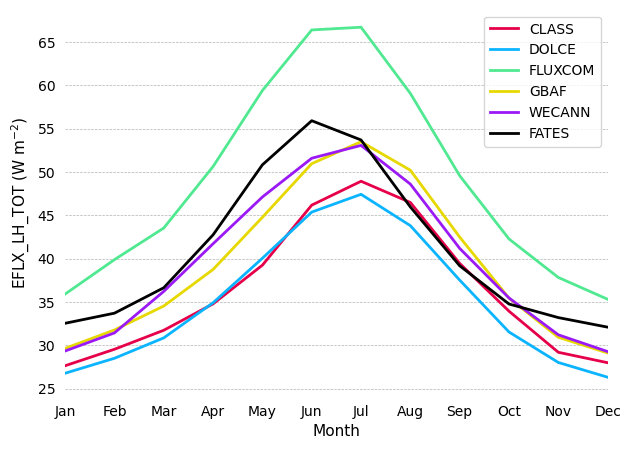

In [59]:
var_name = 'EFLX_LH_TOT'
ilamb_var = ilamb.get_model_da(ilamb_obs, f"{ilamb_config[var_name]['var']}_cycle", ilamb_config[var_name]['models'])
plotting.plot_model_obs_climatology_diff(ilamb_var, fates_clim_crujra[var_name], var_name, var_name, var_dict[var_name]['global_units'])

### Global Annual Values

In [62]:
ds_out = xr.Dataset()
for var_name in [var for var in out_vars if var not in ['SOILWATER_10CM', 'BTRANMN', 'TV', 'Temp', 'Precip', 'RH2M',
                                                       'FSDS']]:
    global_vals = ilamb.get_model_da(ilamb_obs, f"{ilamb_config[var_name]['var']}_global", ilamb_config[var_name]['models'])
    ds_out[var_name] = global_vals.sel(year=slice(2000, 2014)).mean(dim='year').mean(dim='model')

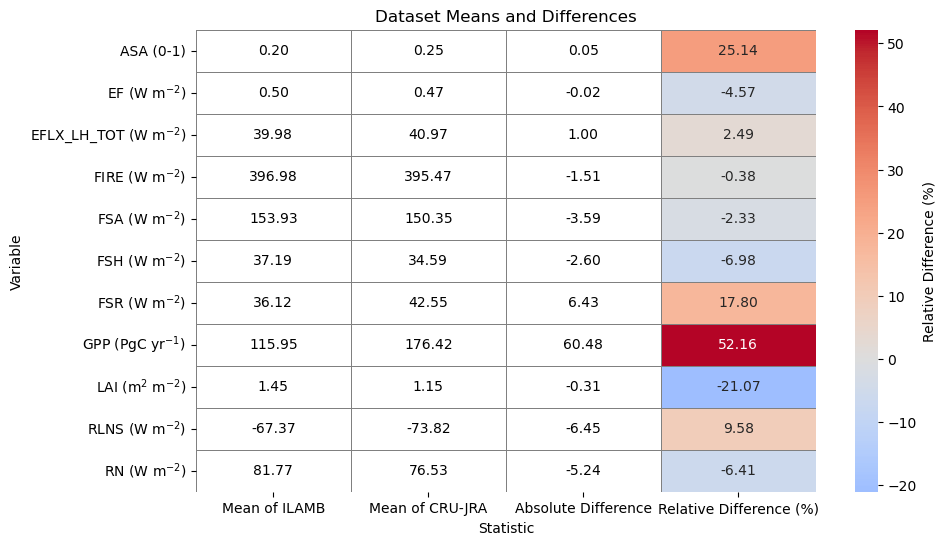

In [63]:
summary_df = plotting.summarize_differences(ds_out, fates_areameans_crujra, 'ILAMB', 'CRU-JRA', var_dict)
plotting.plot_heatmap(summary_df)